# Iterative Closest Point (ICP)

In [1]:
# imports
import numpy as np
import numpy.linalg
import matplotlib.pyplot as plt
%matplotlib inline

## Implementation

In [2]:
import icp.icp as other_icp # Import OK

## Data setup

2D Translation & Rotation matrix:
$$
M =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & t_x \\
\sin(\theta) & \cos(\theta) & t_y \\
0 & 0 & 1 \\
\end{bmatrix}
$$

In [3]:
def randomTransformation2D(maxRot: float = 30, maxTrans: float = 1):
    """
    Generate random 2D rigid transformation centered at the origin and with
    an angle in [-maxRot; maxRot] and a translation in lower than maxTrans

    Parameters
    ----------
    maxRot : float
        maximum rotation in degrees
    maxTrans : float
        maximum norm for the translation vector

    Returns
    -------
    M : np.array
        Generated random 2d rigid transformation
    """

    M = np.zeros((3, 3), dtype=float)

    # Angle
    angle = np.random.uniform(-maxRot, maxRot)
    # Convert degrees to radian
    angle = angle * np.pi / 180
    M[0:2, 0:2] = np.array([[np.cos(angle), -np.sin(angle)],
                              [np.sin(angle), np.cos(angle)]])

    # Translation
    translation = np.random.uniform(-maxTrans / np.sqrt(2), maxTrans / np.sqrt(2), size=2)
    assert np.linalg.norm(translation) <= maxTrans
    M[0:2, 2] = translation
    M[2, 2] = 1

    return M

randomTransformation2D()

array([[ 0.94848938, -0.31680893, -0.46566211],
       [ 0.31680893,  0.94848938,  0.45087486],
       [ 0.        ,  0.        ,  1.        ]])

3D rotation matrix:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/a6821937d5031de282a190f75312353c970aa2df)

Therefore, the **3D translation & rotation matrix** looks like:

If rotation on `z axis`
$$
M =
\begin{bmatrix}
\cos(\theta) & -\sin(\theta) & 0 & t_x\\
\sin(\theta) & \cos(\theta) & 0 & t_y\\
0 & 0 & 1 & t_z\\
0 & 0 & 0 & 1
\end{bmatrix}

In [4]:
def randomTransformation3D(maxRot: float = 30, maxTrans: float = 1):
    """
    Generate random 3D rigid transformation centered at the origin and with
    an angle in [-maxRot; maxRot] and a translation in lower than maxTrans

    Parameters
    ----------
    maxRot : float
        maximum rotation in degrees
    maxTrans : float
        maximum norm for the translation vector

    Returns
    -------
    M : np.array
        Generated random 2d rigid transformation
    """

    M = np.zeros((4, 4), dtype=float)

    # Angle
    angle = np.random.uniform(-maxRot, maxRot)
    # Convert degrees to radian
    angle = angle * np.pi / 180

    # FIXME: random axis rotation
    M[0:3, 0:3] = np.array([[np.cos(angle), -np.sin(angle), 0],
                            [np.sin(angle), np.cos(angle), 0],
                            [0, 0, 1]])

    # Translation
    translation = np.random.uniform(-maxTrans / np.sqrt(3), maxTrans / np.sqrt(3), size=3)
    assert np.linalg.norm(translation) <= maxTrans
    M[0:3, -1] = translation
    M[-1, -1] = 1

    return M

randomTransformation3D()

array([[ 0.99783941, -0.06570016,  0.        ,  0.44338712],
       [ 0.06570016,  0.99783941,  0.        ,  0.28985323],
       [ 0.        ,  0.        ,  1.        , -0.11688003],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [5]:
def generate_2d_square(width:float, nb_points_edge:int) -> np.array:
    """
    Generate 2D square with homogenous points on the edges

    Parameters
    ----------
    width : float
        Size of the square
    nb_points_edge:
        Number of points on each edge

    Returns
    -------
    square_2d : np.array
        Generated 2D square with shape (nb_points_edge * 4, 3)
    """

    edge_points = np.linspace(-width/2, width/2, nb_points_edge)
    # top: x axis different, y = width / 2
    edges_points_2d = np.expand_dims(edge_points, axis=-1)
    top = np.concatenate((edges_points_2d, np.full((len(edge_points), 1), width / 2)), axis=-1)
    # bottom: x axis different, y = -width / 2
    bottom = np.concatenate((edges_points_2d, np.full((len(edge_points), 1), -width / 2)), axis=-1)
    # left: x = -width / 2, y axis different
    left = np.concatenate((np.full((len(edge_points), 1), -width / 2), edges_points_2d), axis=-1)
    # right: x = width / 2, y axis different
    right = np.concatenate((np.full((len(edge_points), 1), width / 2), edges_points_2d), axis=-1)
    # Stack all the points
    points = np.vstack((top, bottom, left, right))
    # Homogenous points
    points = np.concatenate((points, np.ones((len(points), 1))), axis=-1)
    return points


In [6]:
square_width = 1
square_2d = generate_2d_square(width=square_width, nb_points_edge=10)
square_2d.shape, square_2d.dtype

((40, 3), dtype('float64'))

Text(0.5, 1.0, '2D Square')

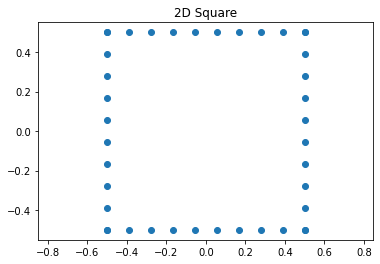

In [7]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.axis('equal')
plt.title("2D Square")

In [8]:
M = randomTransformation2D(maxRot=20, maxTrans=1)
print("Rotation & translation matrix: ", M.shape), print(M),
print("Square 2D shape: ", square_2d.shape)
# Rotate and translate basic square
square_2d_transformed = square_2d @ M.T # FIXME: what it does not work with no transpose...

Rotation & translation matrix:  (3, 3)
[[ 0.94216216  0.33515737  0.36864572]
 [-0.33515737  0.94216216  0.02417466]
 [ 0.          0.          1.        ]]
Square 2D shape:  (40, 3)


Text(0.5, 1.0, '2D Square with rotation')

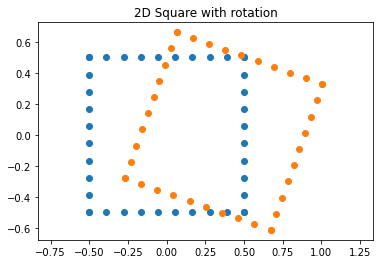

In [9]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.scatter(square_2d_transformed[:, 0], square_2d_transformed[:, 1])
plt.axis('equal')
plt.title("2D Square with rotation")

## Test

Apply `nearest_neighbor` function over the two squared and visualize the square

In [10]:
distances, indices_dst = other_icp.nearest_neighbor(square_2d, square_2d_transformed)
indices_dst

array([26, 26, 27, 27, 27, 28,  1,  2,  3,  4, 10, 10, 11, 12, 12, 13, 14,
       15, 16, 17, 10, 10, 10, 10, 21, 22, 23, 24, 25, 26, 17, 17, 17, 33,
       34, 35,  5,  5,  5,  4])

Text(0.5, 1.0, '2D Square with rotation')

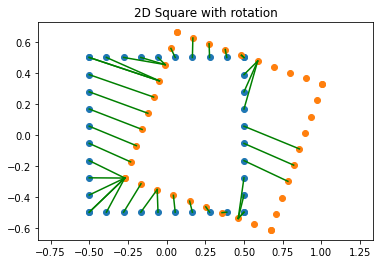

In [11]:
plt.scatter(square_2d[:, 0], square_2d[:, 1])
plt.scatter(square_2d_transformed[:, 0], square_2d_transformed[:, 1])
plt.plot(np.vstack((square_2d[:, 0], square_2d_transformed[indices_dst][:, 0])),
         np.vstack((square_2d[:, 1], square_2d_transformed[indices_dst][:, 1])), color='green')
plt.axis('equal')
plt.title("2D Square with rotation")

FIXME: Commenter

## Variants